In [1]:
from pyspark import SparkContext
sc = SparkContext()
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType
from pyspark.sql import SparkSession
spark = SparkSession(sc) 
sqlContext = SQLContext(sc)
import pyspark.sql.functions as F

In [2]:
# 读取数据
df = spark.read.csv('hotel_bookings.csv', header = True)

In [3]:
# 检查重复行
print('Count of rows: {0}'.format(df.count()))
print('Count of non-duplicated rows: {0}'.format(df.distinct().count()))
# distinct 和 dropDuplicates唯一区别在distinct不能直接指定drop哪些列

Count of rows: 119390
Count of non-duplicated rows: 87396


In [4]:
df.columns

['hotel',
 'is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status',
 'reservation_status_date']

In [5]:
# 按一定的列去除重复行
df = df.dropDuplicates(subset = [c for c in df.columns if c != 'reservation_status_date'])
df.count()

87151

In [6]:
# 检查Na数据
df.where(df.country.isNull())

DataFrame[hotel: string, is_canceled: string, lead_time: string, arrival_date_year: string, arrival_date_month: string, arrival_date_week_number: string, arrival_date_day_of_month: string, stays_in_weekend_nights: string, stays_in_week_nights: string, adults: string, children: string, babies: string, meal: string, country: string, market_segment: string, distribution_channel: string, is_repeated_guest: string, previous_cancellations: string, previous_bookings_not_canceled: string, reserved_room_type: string, assigned_room_type: string, booking_changes: string, deposit_type: string, agent: string, company: string, days_in_waiting_list: string, customer_type: string, adr: string, required_car_parking_spaces: string, total_of_special_requests: string, reservation_status: string, reservation_status_date: string]

In [7]:
# drop if any by row
print(df.na.drop().count())

# at least 2 non-null values will pass
print(df.na.drop(thresh = 2).count())

# use how parameter
print(df.na.drop(how='all').count())
print(df.na.drop(how='any').count())

# based on subset of column
print(df.na.drop(subset=['hotel']).count())

# 这里只有NULL，而NULL没被看做为na
df.select('company').na.drop().show(5)

87151
87151
87151
87151
87151
+-------+
|company|
+-------+
|   NULL|
|   NULL|
|   NULL|
|   NULL|
|   NULL|
+-------+
only showing top 5 rows



In [8]:
# 填充na
df = df.withColumn('lead_time', df.lead_time.cast(IntegerType()))
# 以下fill会根据列的种类进行调整,整型浮点型，字符串
df.na.fill('FILL VALUE') # only fill in string type data
df.na.fill(0) # only fill in number type data
# 指定特定列
df.na.fill('No Name', subset = ['hotel']) # specify the subset
# 或者使用fillna方法
df.fillna('lead_time') 

DataFrame[hotel: string, is_canceled: string, lead_time: int, arrival_date_year: string, arrival_date_month: string, arrival_date_week_number: string, arrival_date_day_of_month: string, stays_in_weekend_nights: string, stays_in_week_nights: string, adults: string, children: string, babies: string, meal: string, country: string, market_segment: string, distribution_channel: string, is_repeated_guest: string, previous_cancellations: string, previous_bookings_not_canceled: string, reserved_room_type: string, assigned_room_type: string, booking_changes: string, deposit_type: string, agent: string, company: string, days_in_waiting_list: string, customer_type: string, adr: string, required_car_parking_spaces: string, total_of_special_requests: string, reservation_status: string, reservation_status_date: string]

In [9]:
# fill the null with mean
# 如果想填充一个值,先计算出这个值，然后设置键值对
df.na.fill({'lead_time': '10', 'company': 'missing_company'})

DataFrame[hotel: string, is_canceled: string, lead_time: int, arrival_date_year: string, arrival_date_month: string, arrival_date_week_number: string, arrival_date_day_of_month: string, stays_in_weekend_nights: string, stays_in_week_nights: string, adults: string, children: string, babies: string, meal: string, country: string, market_segment: string, distribution_channel: string, is_repeated_guest: string, previous_cancellations: string, previous_bookings_not_canceled: string, reserved_room_type: string, assigned_room_type: string, booking_changes: string, deposit_type: string, agent: string, company: string, days_in_waiting_list: string, customer_type: string, adr: string, required_car_parking_spaces: string, total_of_special_requests: string, reservation_status: string, reservation_status_date: string]

In [10]:
# 稍微自动化一点的方法
means = df.agg(
    *[F.mean(c).alias(c) for c in df.columns]
).toPandas().to_dict('records') 

In [11]:
# 检查outlier
# 计算IQR
quantile = df.approxQuantile('lead_time', [.25, .75], 0.01)
IQR = quantile[1] - quantile[0]
# 计算bound
bounds = {}
bounds['lead_time'] = [quantile[0] - 1.5*IQR, quantile[1] + 1.5*IQR]

In [12]:
# 为了合并必须创建一列id进行join
df = df.withColumn('id', F.monotonically_increasing_id())
outliers = df.select(*['id'] + [
    (
        (df['lead_time'] < bounds['lead_time'][0])|
        (df['lead_time'] > bounds['lead_time'][1])
    ).alias('lead_time_o')
])

In [13]:
# 合并并筛选
df.join(outliers, on='id').filter('lead_time_o')

DataFrame[id: bigint, hotel: string, is_canceled: string, lead_time: int, arrival_date_year: string, arrival_date_month: string, arrival_date_week_number: string, arrival_date_day_of_month: string, stays_in_weekend_nights: string, stays_in_week_nights: string, adults: string, children: string, babies: string, meal: string, country: string, market_segment: string, distribution_channel: string, is_repeated_guest: string, previous_cancellations: string, previous_bookings_not_canceled: string, reserved_room_type: string, assigned_room_type: string, booking_changes: string, deposit_type: string, agent: string, company: string, days_in_waiting_list: string, customer_type: string, adr: string, required_car_parking_spaces: string, total_of_special_requests: string, reservation_status: string, reservation_status_date: string, lead_time_o: boolean]

### 描述性统计

In [14]:
# 对于离散型多使用groupby
df.groupby('hotel').count().show()

+------------+-----+
|       hotel|count|
+------------+-----+
|  City Hotel|53265|
|Resort Hotel|33886|
+------------+-----+



In [15]:
# 连续型数据使用describe 等价 summary
df.describe('lead_time').show()

+-------+-----------------+
|summary|        lead_time|
+-------+-----------------+
|  count|            87151|
|   mean|79.72216038829158|
| stddev| 85.9414369437385|
|    min|                0|
|    max|              737|
+-------+-----------------+



### 相关性

In [16]:
df = df.withColumn('previous_cancellations', df.previous_cancellations.cast(IntegerType()))
df = df.withColumn('days_in_waiting_list', df.days_in_waiting_list.cast(IntegerType()))

In [17]:
df.corr('lead_time', 'days_in_waiting_list')

0.13009284646469335

In [18]:
# 创建相关性矩阵
# 创立一个numeric的list
# 将所有numeric columns 放入list中
# 遍历numeric column的次数， 每一次在下面再循环组合当前col和其他col算出corr

In [19]:
# 简单的可视化
hists = df.select('lead_time').rdd.flatMap(
    lambda row: row
).histogram(20)
# 选择lead_time转换为rdd之后进行flatmap，不这么做剩下的是row，接下来进行rdd的histogram方法

<BarContainer object of 20 artists>

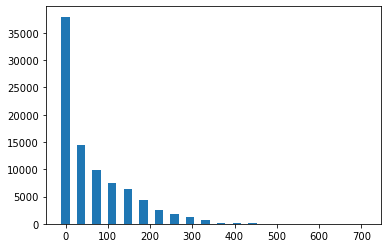

In [20]:
# 直方图
from matplotlib import pyplot as plt
plt.bar(hists[0][:-1], hists[1], width = 20)

In [21]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [22]:
x = hists[0][:-1]
y = hists[1]

p = figure(
    title = 'Histogram of lead_time',
    x_axis_label = 'counts of lead_time',
    y_axis_label = 'lead_time',
    plot_width = 600,
    plot_height = 400
)

p.hbar(
    y = x,
    right =  y,
    height = 20
       )

output_file('index.html')

show(p)